In [1]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [2]:
import os, json

# Create kaggle config folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move uploaded kaggle.json into the correct place
with open("kaggle.json", "r") as f:
    token = json.load(f)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(token, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("Kaggle API key configured.")


Kaggle API key configured.


In [3]:
!pip install -q kaggle
!mkdir -p /content/brats20
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation -p /content/brats20


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [02:05<00:00, 93.0MB/s]
100% 4.16G/4.16G [02:05<00:00, 35.7MB/s]


In [4]:
%cd /content/brats20
!unzip -q brats20-dataset-training-validation.zip
!ls


/content/brats20
BraTS2020_TrainingData	  brats20-dataset-training-validation.zip
BraTS2020_ValidationData


In [5]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader, random_split


In [6]:
!ls /content/brats20


BraTS2020_TrainingData	  brats20-dataset-training-validation.zip
BraTS2020_ValidationData


In [7]:
!ls /content/brats20/*


/content/brats20/brats20-dataset-training-validation.zip

/content/brats20/BraTS2020_TrainingData:
MICCAI_BraTS2020_TrainingData

/content/brats20/BraTS2020_ValidationData:
MICCAI_BraTS2020_ValidationData


In [8]:
!find /content/brats20 -maxdepth 4 -type d -name "*Training*"


/content/brats20/BraTS2020_TrainingData
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_201
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_212
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_045
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_223
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_238
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_087
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_308
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_173
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_356
/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/B

In [9]:
train_root = "/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"


In [10]:
import glob, os

case_dirs = sorted(glob.glob(os.path.join(train_root, "BraTS20_Training_*")))
len(case_dirs)


369

In [11]:
class BraTSDataset(Dataset):
    def __init__(self, case_dirs, roi_size=(96, 96, 96)):
        self.case_dirs = case_dirs
        self.roi_size = roi_size

    def __len__(self):
        return len(self.case_dirs)

    def _load_nifti(self, path):
        img = nib.load(path)
        data = img.get_fdata().astype(np.float32)
        return data  # [D, H, W]

    def _zscore(self, vol):
        m = vol.mean()
        s = vol.std()
        if s < 1e-6:
            return vol * 0.0
        return (vol - m) / s

    def _center_crop(self, vol, roi):
        D, H, W = vol.shape
        rd, rh, rw = roi
        sd = max((D - rd) // 2, 0)
        sh = max((H - rh) // 2, 0)
        sw = max((W - rw) // 2, 0)
        ed = sd + rd
        eh = sh + rh
        ew = sw + rw
        return vol[sd:ed, sh:eh, sw:ew]

    def __getitem__(self, idx):
        case_dir = self.case_dirs[idx]
        case_id = os.path.basename(case_dir)

        flair = self._load_nifti(os.path.join(case_dir, case_id + "_flair.nii.gz"))
        t1    = self._load_nifti(os.path.join(case_dir, case_id + "_t1.nii.gz"))
        t1ce  = self._load_nifti(os.path.join(case_dir, case_id + "_t1ce.nii.gz"))
        t2    = self._load_nifti(os.path.join(case_dir, case_id + "_t2.nii.gz"))
        seg   = self._load_nifti(os.path.join(case_dir, case_id + "_seg.nii.gz"))

        # Normalize each modality
        flair = self._zscore(flair)
        t1    = self._zscore(t1)
        t1ce  = self._zscore(t1ce)
        t2    = self._zscore(t2)

        # Center crop all to same roi
        rd, rh, rw = self.roi_size
        flair = self._center_crop(flair, self.roi_size)
        t1    = self._center_crop(t1, self.roi_size)
        t1ce  = self._center_crop(t1ce, self.roi_size)
        t2    = self._center_crop(t2, self.roi_size)
        seg   = self._center_crop(seg,  self.roi_size)

        # Stack modalities → [4, D, H, W]
        image = np.stack([flair, t1, t1ce, t2], axis=0)
        image = torch.from_numpy(image)           # float32

        # segmentation as int64 (labels: 0,1,2,4)
        seg = torch.from_numpy(seg.astype(np.int64))

        return image, seg


In [13]:
dataset = BraTSDataset(case_dirs, roi_size=(96, 96, 96))

# simple train/val split
val_fraction = 0.1
val_len = int(len(dataset) * val_fraction)
train_len = len(dataset) - val_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

sample_img, sample_seg = next(iter(train_loader))
print("image shape:", sample_img.shape)  # [B, 4, D, H, W]
print("seg shape:", sample_seg.shape)    # [B, D, H, W]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/nibabel/loadsave.py", line 101, in load
    stat_result = os.stat(filename)
                  ^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_120/BraTS20_Training_120_flair.nii.gz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataset.py", line 416, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2588040521.py", line 36, in __getitem__
    flair = self._load_nifti(os.path.join(case_dir, case_id + "_flair.nii.gz"))
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2588040521.py", line 10, in _load_nifti
    img = nib.load(path)
          ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nibabel/loadsave.py", line 103, in load
    raise FileNotFoundError(f"No such file or no access: '{filename}'")
FileNotFoundError: No such file or no access: '/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_120/BraTS20_Training_120_flair.nii.gz'


In [14]:
!ls "/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_262"


BraTS20_Training_262_flair.nii	BraTS20_Training_262_t1.nii
BraTS20_Training_262_seg.nii	BraTS20_Training_262_t2.nii
BraTS20_Training_262_t1ce.nii


In [15]:
import glob
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, case_dirs, roi_size=(96, 96, 96)):
        self.roi_size = roi_size
        self.samples = []

        # Build a list of cases that really have all 4 modalities + seg
        for case_dir in case_dirs:
            case_id = os.path.basename(case_dir)

            def find_mod(suffix):
                pattern = os.path.join(case_dir, f"*_{suffix}.nii*")
                matches = glob.glob(pattern)
                return matches[0] if matches else None

            flair = find_mod("flair")
            t1    = find_mod("t1")
            t1ce  = find_mod("t1ce")
            t2    = find_mod("t2")
            seg   = find_mod("seg")

            if all([flair, t1, t1ce, t2, seg]):
                self.samples.append({
                    "flair": flair,
                    "t1": t1,
                    "t1ce": t1ce,
                    "t2": t2,
                    "seg": seg,
                })
            else:
                # You can print or log missing cases if you want
                # print("Skipping incomplete case:", case_dir)
                pass

        print(f"Using {len(self.samples)} cases out of {len(case_dirs)}")

    def __len__(self):
        return len(self.samples)

    def _load_nifti(self, path):
        img = nib.load(path)
        data = img.get_fdata().astype(np.float32)
        return data  # [D, H, W]

    def _zscore(self, vol):
        m = vol.mean()
        s = vol.std()
        if s < 1e-6:
            return vol * 0.0
        return (vol - m) / s

    def _center_crop(self, vol, roi):
        D, H, W = vol.shape
        rd, rh, rw = roi
        sd = max((D - rd) // 2, 0)
        sh = max((H - rh) // 2, 0)
        sw = max((W - rw) // 2, 0)
        ed = sd + rd
        eh = sh + rh
        ew = sw + rw
        return vol[sd:ed, sh:eh, sw:ew]

    def __getitem__(self, idx):
        sample = self.samples[idx]

        flair = self._load_nifti(sample["flair"])
        t1    = self._load_nifti(sample["t1"])
        t1ce  = self._load_nifti(sample["t1ce"])
        t2    = self._load_nifti(sample["t2"])
        seg   = self._load_nifti(sample["seg"])

        flair = self._zscore(flair)
        t1    = self._zscore(t1)
        t1ce  = self._zscore(t1ce)
        t2    = self._zscore(t2)

        flair = self._center_crop(flair, self.roi_size)
        t1    = self._center_crop(t1,    self.roi_size)
        t1ce  = self._center_crop(t1ce,  self.roi_size)
        t2    = self._center_crop(t2,    self.roi_size)
        seg   = self._center_crop(seg,   self.roi_size)

        image = np.stack([flair, t1, t1ce, t2], axis=0)
        image = torch.from_numpy(image)                # [4, D, H, W]
        seg   = torch.from_numpy(seg.astype(np.int64)) # [D, H, W]

        return image, seg


In [16]:
train_root = "/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

case_dirs = sorted(glob.glob(os.path.join(train_root, "BraTS20_Training_*")))
len(case_dirs)


369

In [17]:
from torch.utils.data import random_split, DataLoader

dataset = BraTSDataset(case_dirs, roi_size=(96, 96, 96))

val_fraction = 0.1
val_len = int(len(dataset) * val_fraction)
train_len = len(dataset) - val_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

sample_img, sample_seg = next(iter(train_loader))
print("image shape:", sample_img.shape)
print("seg shape:", sample_seg.shape)


Using 368 cases out of 369
image shape: torch.Size([1, 4, 96, 96, 96])
seg shape: torch.Size([1, 96, 96, 96])


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------
# Window ops
# ------------------------------
def window_partition_3d(x, window):
    B, D, H, W, C = x.shape
    wd, wh, ww = window
    x = x.view(
        B,
        D // wd, wd,
        H // wh, wh,
        W // ww, ww,
        C,
    )
    windows = x.permute(0,1,3,5,2,4,6,7).contiguous()
    windows = windows.view(-1, wd * wh * ww, C)
    return windows


def window_reverse_3d(windows, window, B, D, H, W, C):
    wd, wh, ww = window
    x = windows.view(
        B, D // wd, H // wh, W // ww, wd, wh, ww, C
    )
    x = x.permute(0,1,4,2,5,3,6,7).contiguous()
    x = x.view(B, D, H, W, C)
    return x


# ------------------------------
# Attention block
# ------------------------------
class WindowAttention3D(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        Bn, N, C = x.shape
        qkv = self.qkv(x).reshape(Bn, N, 3, self.heads, C // self.heads)
        q, k, v = qkv[:,:,0], qkv[:,:,1], qkv[:,:,2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(-1)

        out = (attn @ v).reshape(Bn, N, C)
        return self.proj(out)


# ------------------------------
# MLP
# ------------------------------
class MLP(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim * mult)
        self.fc2 = nn.Linear(dim * mult, dim)
        self.act = nn.GELU()

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))


# ------------------------------
# Swin Block
# ------------------------------
class SwinBlock3D(nn.Module):
    def __init__(self, dim, heads, window):
        super().__init__()
        self.window = window
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention3D(dim, heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim)

    def forward(self, x, dims):
        B, N, C = x.shape
        D, H, W = dims

        sh = x
        x = self.norm1(x).view(B, D, H, W, C)

        win = window_partition_3d(x, self.window)
        win = self.attn(win)
        x = window_reverse_3d(win, self.window, B, D, H, W, C)

        x = x.view(B, N, C)
        x = sh + x
        x = x + self.mlp(self.norm2(x))

        return x, dims


# ------------------------------
# Patch Embed + Patch Merging
# ------------------------------
class PatchEmbed3D(nn.Module):
    def __init__(self, in_channels, dim):
        super().__init__()
        self.proj = nn.Conv3d(in_channels, dim, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.proj(x)
        B, C, D, H, W = x.shape
        return x.flatten(2).transpose(1,2), (D, H, W)


class PatchMerging3D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.reduction = nn.Linear(dim*8, dim*2)

    def forward(self, x, dims):
        B, N, C = x.shape
        D,H,W = dims

        x = x.view(B, D, H, W, C)

        x0 = x[:,0::2,0::2,0::2,:]
        x1 = x[:,0::2,0::2,1::2,:]
        x2 = x[:,0::2,1::2,0::2,:]
        x3 = x[:,0::2,1::2,1::2,:]
        x4 = x[:,1::2,0::2,0::2,:]
        x5 = x[:,1::2,0::2,1::2,:]
        x6 = x[:,1::2,1::2,0::2,:]
        x7 = x[:,1::2,1::2,1::2,:]

        x = torch.cat([x0,x1,x2,x3,x4,x5,x6,x7], -1)
        x = x.view(B, -1, C*8)

        x = self.reduction(x)
        return x, (D//2, H//2, W//2)


# ------------------------------
# Final Swin-UNETR 3D
# ------------------------------
class SwinUNETR3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, dim=24, window=(2,3,3)):
        super().__init__()

        # Encoder
        self.patch = PatchEmbed3D(in_channels, dim)

        self.s1 = SwinBlock3D(dim, heads=2, window=window)
        self.m1 = PatchMerging3D(dim)

        self.s2 = SwinBlock3D(dim*2, heads=4, window=window)
        self.m2 = PatchMerging3D(dim*2)

        self.s3 = SwinBlock3D(dim*4, heads=8, window=window)
        self.m3 = PatchMerging3D(dim*4)

        self.s4 = SwinBlock3D(dim*8, heads=8, window=window)

        # Decoder
        self.up3 = nn.ConvTranspose3d(dim*8, dim*4, 2, 2)
        self.c3 = nn.Conv3d(dim*8, dim*4, 3, padding=1)

        self.up2 = nn.ConvTranspose3d(dim*4, dim*2, 2, 2)
        self.c2 = nn.Conv3d(dim*4, dim*2, 3, padding=1)

        self.up1 = nn.ConvTranspose3d(dim*2, dim, 2, 2)
        self.c1 = nn.Conv3d(dim*2, dim, 3, padding=1)

        self.up0 = nn.ConvTranspose3d(dim, dim, 2, 2)
        self.c0 = nn.Conv3d(dim, dim, 3, padding=1)

        self.out = nn.Conv3d(dim, out_channels, 1)

    def to_feat(self, t, dims):
        D,H,W = dims
        return t.view(t.shape[0], D,H,W,-1).permute(0,4,1,2,3)

    def forward(self, x):

        t, d = self.patch(x)

        # Encoder
        t1, d1 = self.s1(t, d)
        t1d, d1d = self.m1(t1, d1)

        t2, d2 = self.s2(t1d, d1d)
        t2d, d2d = self.m2(t2, d2)

        t3, d3 = self.s3(t2d, d2d)
        t3d, d3d = self.m3(t3, d3)

        t4, d4 = self.s4(t3d, d3d)

        # Skip features
        f1 = self.to_feat(t1, d1)
        f2 = self.to_feat(t2, d2)
        f3 = self.to_feat(t3, d3)
        f4 = self.to_feat(t4, d4)

        # Decoder
        x = self.up3(f4)
        x = torch.cat([x, f3], 1)
        x = self.c3(x)

        x = self.up2(x)
        x = torch.cat([x, f2], 1)
        x = self.c2(x)

        x = self.up1(x)
        x = torch.cat([x, f1], 1)
        x = self.c1(x)

        x = self.up0(x)
        x = self.c0(x)

        return self.out(x)


In [28]:
model = SwinUNETR3D(in_channels=4, out_channels=4, dim=24, window=(2,3,3)).cuda()

x = torch.randn(1,4,96,96,96).cuda()
y = model(x)
print("OUTPUT:", y.shape)



OUTPUT: torch.Size([1, 4, 96, 96, 96])


In [29]:
import torch.nn.functional as F

# ----- Dice loss -----
def dice_loss(pred, target, eps=1e-5):
    """
    pred: [B, C, D, H, W] (softmax probabilities)
    target: [B, D, H, W] integer labels {0,1,2,3}
    """
    num_classes = pred.shape[1]
    pred_onehot = F.one_hot(torch.argmax(pred, dim=1), num_classes).permute(0,4,1,2,3)
    target_onehot = F.one_hot(target, num_classes).permute(0,4,1,2,3)

    dims = (0,2,3,4)
    intersection = (pred_onehot * target_onehot).sum(dims)
    union = pred_onehot.sum(dims) + target_onehot.sum(dims)

    dice = 1 - (2 * intersection + eps) / (union + eps)
    return dice.mean()

# ----- Combined Loss -----
def total_loss(logits, seg):
    ce = F.cross_entropy(logits, seg)
    dice = dice_loss(F.softmax(logits, dim=1), seg)
    return ce + dice

# ----- Remap BraTS labels (4 → 3) -----
def remap(seg):
    seg = seg.clone()
    seg[seg == 4] = 3
    return seg

# ----- Optimizer -----
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [30]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


In [31]:
model.train()

EPOCHS = 3

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    running_loss = 0.0

    for i, (img, seg) in enumerate(train_loader):

        img = img.to(device)
        seg = remap(seg.to(device))

        logits = model(img)
        loss = total_loss(logits, seg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 20 == 0:
            print(f"  step {i+1}, loss = {loss.item():.4f}")

    print(f"Epoch Loss: {running_loss/len(train_loader):.4f}")



Epoch 1/3
  step 20, loss = 1.9069
  step 40, loss = 1.5066
  step 60, loss = 1.8630
  step 80, loss = 1.1869
  step 100, loss = 1.0165
  step 120, loss = 0.7247
  step 140, loss = 1.0613
  step 160, loss = 1.0109
  step 180, loss = 0.8043
  step 200, loss = 0.9585
  step 220, loss = 0.7679
  step 240, loss = 0.7865
  step 260, loss = 0.8155
  step 280, loss = 0.8036
  step 300, loss = 0.9088
  step 320, loss = 0.7187
Epoch Loss: 1.0280

Epoch 2/3
  step 20, loss = 0.7522
  step 40, loss = 0.7821
  step 60, loss = 0.6708
  step 80, loss = 0.6770
  step 100, loss = 0.6001
  step 120, loss = 0.7328
  step 140, loss = 0.6239
  step 160, loss = 0.8064
  step 180, loss = 1.0365
  step 200, loss = 0.7297
  step 220, loss = 1.0280
  step 240, loss = 0.5412
  step 260, loss = 0.8267
  step 280, loss = 0.6330
  step 300, loss = 0.6204
  step 320, loss = 0.6651
Epoch Loss: 0.7743

Epoch 3/3
  step 20, loss = 0.9592
  step 40, loss = 0.6879
  step 60, loss = 1.3114
  step 80, loss = 0.5146
  ste

In [32]:
import torch.nn.functional as F

def sliding_window_inference(img, model, window=96, overlap=0.5):
    """
    img: [1,4,D,H,W]
    """
    model.eval()
    _, _, D, H, W = img.shape

    stride = int(window * (1 - overlap))

    output = torch.zeros(1, 4, D, H, W, device=img.device)
    count  = torch.zeros(1, 4, D, H, W, device=img.device)

    for d in range(0, D-window+1, stride):
        for h in range(0, H-window+1, stride):
            for w in range(0, W-window+1, stride):

                patch = img[:,:,d:d+window, h:h+window, w:w+window]
                logits = model(patch)
                probs  = F.softmax(logits, dim=1)

                output[:,:,d:d+window, h:h+window, w:w+window] += probs
                count[:,:,d:d+window, h:h+window, w:w+window]  += 1

    output /= count
    return torch.argmax(output, dim=1)   # [1, D, H, W]


In [33]:
with torch.no_grad():
    pred_seg = sliding_window_inference(img, model)


In [34]:
import matplotlib.pyplot as plt

def show_slice(img, seg, pred, slice_idx=60):
    """
    img  : [4,D,H,W]  (we display FLAIR modality)
    seg  : [D,H,W]
    pred : [D,H,W]
    """
    flair = img[0].cpu().numpy()
    seg   = seg.cpu().numpy()
    pred  = pred.cpu().numpy()

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("FLAIR")
    plt.imshow(flair[:,:,slice_idx], cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(seg[:,:,slice_idx], cmap='jet')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(pred[:,:,slice_idx], cmap='jet')
    plt.axis('off')

    plt.show()


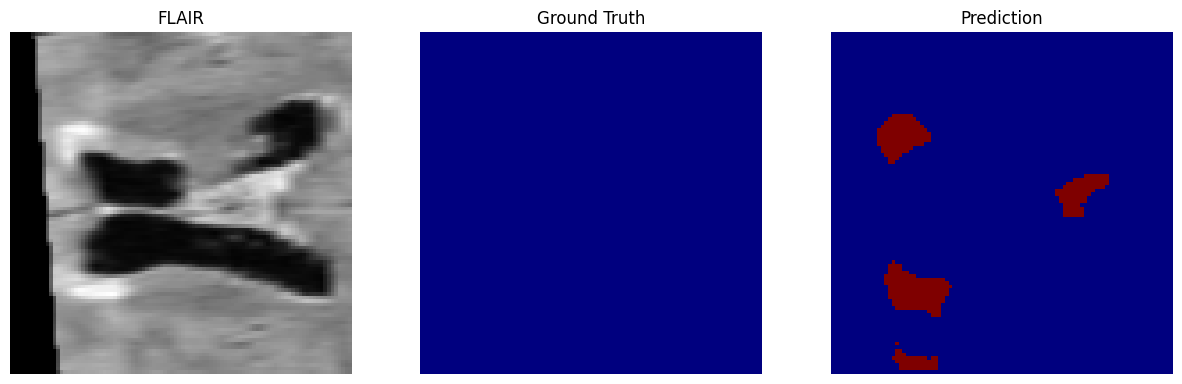

In [35]:
img, seg = next(iter(val_loader))
img, seg = img.to(device), seg.to(device)
pred = sliding_window_inference(img, model)

show_slice(img[0], seg[0], pred[0], slice_idx=60)


In [36]:
torch.save(model.state_dict(), "/content/swin_unetr_braTS.pth")
print("Model saved.")


Model saved.


In [37]:
model = SwinUNETR3D(in_channels=4, out_channels=4, dim=24, window=(2,3,3)).to(device)
model.load_state_dict(torch.load("/content/swin_unetr_braTS.pth"))
model.eval()
print("Checkpoint loaded!")


Checkpoint loaded!


In [46]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def interactive_3panel(img, seg=None, pred=None, modality=0):
    """
    img:   [4, D, H, W]
    seg:   [D, H, W]
    pred:  [D, H, W]
    modality: which modality to show (0=FLAIR)
    """

    img_np  = img[modality].cpu().numpy()
    seg_np  = seg.cpu().numpy() if seg is not None else None
    pred_np = pred.cpu().numpy() if pred is not None else None

    D = img_np.shape[0]

    @interact(slice_idx = IntSlider(min=0, max=D-1, step=1, value=0))
    def update(slice_idx):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # FLAIR
        axes[0].imshow(img_np[slice_idx], cmap='gray')
        axes[0].set_title(f"FLAIR (slice {slice_idx})")
        axes[0].axis('off')

        # Ground Truth
        if seg_np is not None:
            axes[1].imshow(seg_np[slice_idx], cmap='jet')
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')

        # Prediction
        if pred_np is not None:
            axes[2].imshow(pred_np[slice_idx], cmap='jet')
        axes[2].set_title("Prediction")
        axes[2].axis('off')

        plt.show()


In [47]:
img, seg = next(iter(val_loader))
img = img[0].to(device)  # shape [4,D,H,W]
seg = seg[0].to(device)

# inference
with torch.no_grad():
    pred = sliding_window_inference(img.unsqueeze(0), model)[0]


In [48]:
interactive_3panel(img, seg, pred, modality=0)


interactive(children=(IntSlider(value=0, description='slice_idx', max=95), Output()), _dom_classes=('widget-in…